In [1]:
from lattice_train import ModulePL, load_datasets
import util

chkpt_dir = "./lattice_pt"
# load most recent model
checkpoint = util.latest_file(chkpt_dir)
print("loading", checkpoint)
model = ModulePL.load_from_checkpoint(checkpoint)

loading ./lattice_pt/epoch=67-step=6800-v1.ckpt


In [3]:
import itertools
def predict(model, loader, count):
    correct = []
    predictions = []
    with torch.no_grad():
        for data_x, data_y in itertools.islice(loader, count):
            pred_y = model(data_x)
            for d, p in zip(data_y, pred_y):
                correct.append(np.array(d.detach()))
                predictions.append(np.array(p.detach()))
            if len(correct) > count:
                break
        return np.array(predictions), np.array(correct)

available features: 10143 available grids: 10140
0 missing features


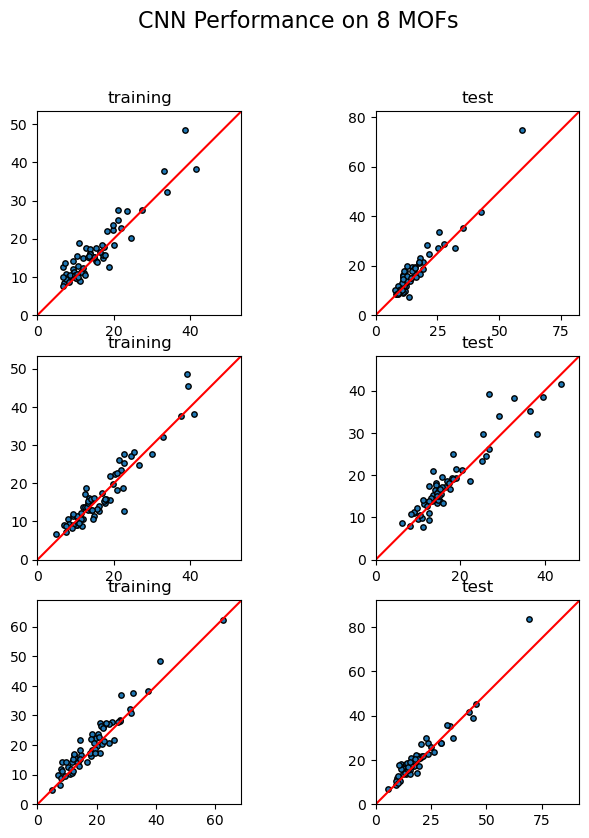

In [6]:
# plot performance
import matplotlib.pyplot as plt
import torch
import numpy as np

train_loader, validation_loader, test_loader = load_datasets()

count = min(100, len(test_loader))

feature_range = (0, 3)
loaders = dict(
    training=train_loader,
    test=test_loader
)
fig, axs = plt.subplots(feature_range[1]-feature_range[0], len(loaders), figsize=(len(loaders)*4, 3*(feature_range[1]-feature_range[0])), dpi=100)
fig.suptitle(f"CNN Performance on {count} MOFs", fontsize=16, verticalalignment='center')

for i, (title, loader) in enumerate(loaders.items()):
    x, x_hat = predict(model, loader, count)
    for feature_idx in range(*feature_range):
        ax = axs[feature_idx][i]
        fx = x[:,feature_idx]
        fx_hat = x_hat[:,feature_idx]
        lim = [0, max(*fx, *fx_hat)*1.1]
        ax.scatter(fx, fx_hat, s=15, linewidths=1, edgecolors='black')

        ax.title.set_text(title)
        ax.set_aspect('equal')
        ax.set_xlim(lim)
        ax.set_ylim(lim)
        # plt.xscale('log')
        # plt.yscale('log')
        ax.plot([0, lim[1]], [0, lim[1]], color='red')

plt.show()

In [ ]:
# load specific model
import util
from basic_net import BasicModel
if True:
    # checkpoint = "lattice_pt/saved_checkpoints/basic_net_lattice_constants/epoch=216-step=21700.ckpt"
    # print("loading", checkpoint)
    # saved_model = ModulePL.load_from_checkpoint(checkpoint)
    # torch.save(saved_model.model.state_dict(), "lattice_pt/saved_checkpoints/basic_net_lattice_constants/model.pt")
    saved_model = BasicModel(6, 3, 32, 0.2)
    saved_model.load_state_dict(torch.load("lattice_pt/saved_checkpoints/basic_net_lattice_constants/model.pt"))
    saved_model.requires_grad_(False)